### This file includes the following content:
- Dara preprocessing
1. Log transformation for skewed data 
2. One-Hot Encoding for categorical features
3. Scaling for numerical features
- Models
1. Support Vector Machine (SVM)
2. Logistic Regression Model
3. Ensemble Methods

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv('cleaned_data.csv')

In [4]:
df.head()

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,CUS_0x1000,January,17,Lawyer,30625.94,2706.161667,6.0,5.0,27,2.0,...,Bad,1562.91,26.612093,10.166667,Yes,42.94109,244.750283,Low_spent_Large_value_payments,252.924793,Standard
1,CUS_0x1000,February,17,Lawyer,30625.94,2706.161667,6.0,5.0,27,2.0,...,Bad,1562.91,29.439759,10.250000,Yes,42.94109,176.132567,High_spent_Small_value_payments,311.542510,Poor
2,CUS_0x1000,March,17,Lawyer,30625.94,2706.161667,6.0,5.0,27,2.0,...,Bad,1562.91,38.285928,10.333333,Yes,42.94109,109.056519,High_spent_Medium_value_payments,368.618557,Poor
3,CUS_0x1000,April,17,Lawyer,30625.94,2706.161667,6.0,5.0,27,2.0,...,Bad,1562.91,32.843081,10.416667,Yes,42.94109,87.909909,High_spent_Medium_value_payments,419.765167,Poor
4,CUS_0x1000,May,17,Lawyer,30625.94,2706.161667,6.0,5.0,27,2.0,...,Bad,1562.91,32.330508,10.500000,Yes,42.94109,191.834767,Low_spent_Large_value_payments,305.840309,Poor


In [5]:
df['Monthly_Balance'].describe()

count    100000.000000
mean        395.846943
std         218.975178
min           0.000000
25%         266.732614
50%         334.065569
75%         467.378940
max        1602.040519
Name: Monthly_Balance, dtype: float64

In [6]:
# Create a summary DataFrame with data types and unique counts
summary = pd.DataFrame({
    'Type': df.dtypes,
    'Unique Values': df.nunique()
})
print(summary, len(df.columns)) # Type_of_Loan has too many values...why?

                             Type  Unique Values
Customer_ID                object          12500
Month                      object              8
Age                         int64             43
Occupation                 object             15
Annual_Income             float64          13487
Monthly_Inhand_Salary     float64          13235
Num_Bank_Accounts         float64             12
Num_Credit_Card           float64             12
Interest_Rate               int64           1750
Num_of_Loan               float64             10
Type_of_Loan               object           6260
Delay_from_due_date       float64             68
Num_of_Delayed_Payment    float64             29
Changed_Credit_Limit      float64           3716
Num_Credit_Inquiries      float64             18
Credit_Mix                 object              3
Outstanding_Debt          float64          12203
Credit_Utilization_Ratio  float64         100000
Credit_History_Age        float64            542
Payment_of_Min_Amoun

### Log transformation for skewed data
We only transformed one skewed data for demonstration purpose. This part was not included in our model training because by the time we noticed this part, there was insufficient time to renew all the features and retrain all the models.  

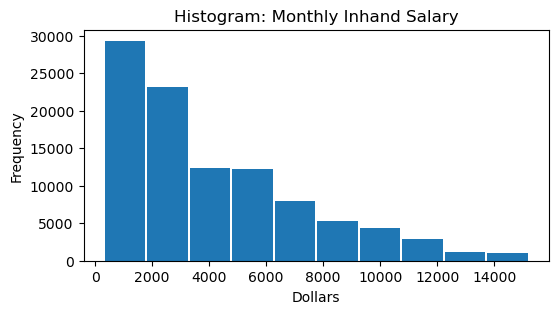

In [68]:
# Show the original data distribution
plt.figure(figsize=(6, 3))
plt.hist(df.Monthly_Inhand_Salary, rwidth= 0.95)
plt.ylabel('Frequency')
plt.xlabel('Dollars')
plt.title('Histogram: Monthly Inhand Salary')
plt.show()

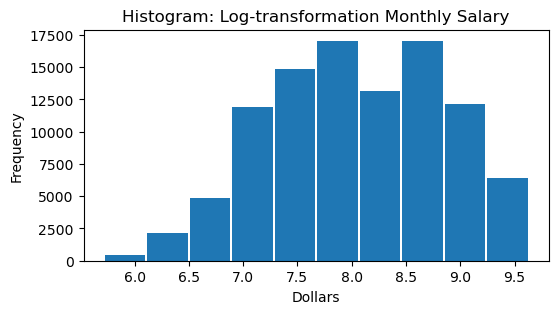

In [69]:
# log transformation for the skewed data
plt.figure(figsize=(6, 3))
salary_log = np.log(df.Monthly_Inhand_Salary)
plt.hist(salary_log, rwidth = 0.95)
plt.ylabel('Frequency')
plt.xlabel('Dollars')
plt.title('Histogram: Log-transformation Monthly Salary')
plt.show()

#### Dealing with 'Type_of_Loan'
`'Type_of_Loan' is tricky because it has many unique values and they are stored as a string. We can't use PCA here since it only works for numerical data. If we use one-hot encoding directly, we would end up with 6,000 columns, which is inefficient.

To address this, I tried to understand what those values actually represent. After observing the data, I noticed that the values are made up of multiple strings combined and separated by commas.

My assumption is that there are a set of "basic" values that are being combined to create these 6,000 unique values. The number of distinct "basic" values should be much fewer, which means we could split these combined strings and one-hot encoding them, reducing the dimensionality significantly.`

In [7]:
print(df['Type_of_Loan'][0:15])

0             Credit-Builder Loan, and Home Equity Loan
1             Credit-Builder Loan, and Home Equity Loan
2             Credit-Builder Loan, and Home Equity Loan
3             Credit-Builder Loan, and Home Equity Loan
4             Credit-Builder Loan, and Home Equity Loan
5             Credit-Builder Loan, and Home Equity Loan
6             Credit-Builder Loan, and Home Equity Loan
7             Credit-Builder Loan, and Home Equity Loan
8     Not Specified, Home Equity Loan, Credit-Builde...
9     Not Specified, Home Equity Loan, Credit-Builde...
10    Not Specified, Home Equity Loan, Credit-Builde...
11    Not Specified, Home Equity Loan, Credit-Builde...
12    Not Specified, Home Equity Loan, Credit-Builde...
13    Not Specified, Home Equity Loan, Credit-Builde...
14    Not Specified, Home Equity Loan, Credit-Builde...
Name: Type_of_Loan, dtype: object


In [8]:
# Remove all instances of "and " and also strip leading/trailing whitespaces properly
df['Type_of_Loan_Cleaned'] = df['Type_of_Loan'].str.replace(r'\band\b', '',
                                                            regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()

# Now split the cleaned values
df['Type_of_Loan_Split'] = df['Type_of_Loan_Cleaned'].str.split(', ')
print(df['Type_of_Loan_Split'].head())

0    [Credit-Builder Loan, Home Equity Loan]
1    [Credit-Builder Loan, Home Equity Loan]
2    [Credit-Builder Loan, Home Equity Loan]
3    [Credit-Builder Loan, Home Equity Loan]
4    [Credit-Builder Loan, Home Equity Loan]
Name: Type_of_Loan_Split, dtype: object


In [9]:
# check if 'and Home Equity Loan' is counted as 'Home Equity Loan'
mlb = MultiLabelBinarizer()
loan_one_hot = mlb.fit_transform(df['Type_of_Loan_Split'])
loan_one_hot_df = pd.DataFrame(loan_one_hot, columns=mlb.classes_)
print(loan_one_hot[:6])
print(loan_one_hot_df.head()) 

[[0 1 0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0]]
   Auto Loan  Credit-Builder Loan  Debt Consolidation Loan  Home Equity Loan  \
0          0                    1                        0                 1   
1          0                    1                        0                 1   
2          0                    1                        0                 1   
3          0                    1                        0                 1   
4          0                    1                        0                 1   

   Mortgage Loan  Not Specified  Payday Loan  Personal Loan  Student Loan  
0              0              0            0              0             0  
1              0              0            0              0             0  
2              0              0            0              0             0  
3              0              0            0              0             0  
4           

In [10]:
# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_new_typeOfLoan = pd.concat([df, loan_one_hot_df], axis=1)

In [11]:
# Drop the unecessary col: 'Customer_ID', 'Type_of_Loan ', 
# 'Type_of_Loan_Split','Type_of_Loan_Cleaned', 'Credit_Score'
# Drop 'Annual_Income'cuz monthly salary and annual income are highly related, so only keep one

convert_df = df_new_typeOfLoan.drop(['Customer_ID', 'Annual_Income','Type_of_Loan', 
    'Type_of_Loan_Split','Type_of_Loan_Cleaned', 'Credit_Score'], axis=1) 
print(convert_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Month                     100000 non-null  object 
 1   Age                       100000 non-null  int64  
 2   Occupation                100000 non-null  object 
 3   Monthly_Inhand_Salary     100000 non-null  float64
 4   Num_Bank_Accounts         100000 non-null  float64
 5   Num_Credit_Card           100000 non-null  float64
 6   Interest_Rate             100000 non-null  int64  
 7   Num_of_Loan               100000 non-null  float64
 8   Delay_from_due_date       100000 non-null  float64
 9   Num_of_Delayed_Payment    100000 non-null  float64
 10  Changed_Credit_Limit      100000 non-null  float64
 11  Num_Credit_Inquiries      100000 non-null  float64
 12  Credit_Mix                100000 non-null  object 
 13  Outstanding_Debt          100000 non-null  fl

### We can finally address other str columns

In [12]:
df_dummies = pd.get_dummies(convert_df, columns=['Occupation','Month',
                                         'Credit_Mix','Payment_of_Min_Amount',
                                        'Payment_Behaviour'], drop_first=False)

In [13]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 60 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   Age                                                 100000 non-null  int64  
 1   Monthly_Inhand_Salary                               100000 non-null  float64
 2   Num_Bank_Accounts                                   100000 non-null  float64
 3   Num_Credit_Card                                     100000 non-null  float64
 4   Interest_Rate                                       100000 non-null  int64  
 5   Num_of_Loan                                         100000 non-null  float64
 6   Delay_from_due_date                                 100000 non-null  float64
 7   Num_of_Delayed_Payment                              100000 non-null  float64
 8   Changed_Credit_Limit                                100000 non-nu

In [14]:
df_final = df_dummies.copy()

In [33]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 60 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   Age                                                 100000 non-null  int64  
 1   Monthly_Inhand_Salary                               100000 non-null  float64
 2   Num_Bank_Accounts                                   100000 non-null  float64
 3   Num_Credit_Card                                     100000 non-null  float64
 4   Interest_Rate                                       100000 non-null  int64  
 5   Num_of_Loan                                         100000 non-null  float64
 6   Delay_from_due_date                                 100000 non-null  float64
 7   Num_of_Delayed_Payment                              100000 non-null  float64
 8   Changed_Credit_Limit                                100000 non-nu

In [15]:
## Version 2 : add back 'Annual_Income', because other peers' models use it and it may have better result
df_final2 = df_final.copy()
df_final2 = pd.concat([df_final2, df['Annual_Income']], axis=1)
df_final2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 61 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   Age                                                 100000 non-null  int64  
 1   Monthly_Inhand_Salary                               100000 non-null  float64
 2   Num_Bank_Accounts                                   100000 non-null  float64
 3   Num_Credit_Card                                     100000 non-null  float64
 4   Interest_Rate                                       100000 non-null  int64  
 5   Num_of_Loan                                         100000 non-null  float64
 6   Delay_from_due_date                                 100000 non-null  float64
 7   Num_of_Delayed_Payment                              100000 non-null  float64
 8   Changed_Credit_Limit                                100000 non-nu

## Scale the numeric data

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [17]:
df_final.iloc[:, 0:16] = scaler.fit_transform(df_final.iloc[:, 0:16])

In [18]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 60 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   Age                                                 100000 non-null  float64
 1   Monthly_Inhand_Salary                               100000 non-null  float64
 2   Num_Bank_Accounts                                   100000 non-null  float64
 3   Num_Credit_Card                                     100000 non-null  float64
 4   Interest_Rate                                       100000 non-null  float64
 5   Num_of_Loan                                         100000 non-null  float64
 6   Delay_from_due_date                                 100000 non-null  float64
 7   Num_of_Delayed_Payment                              100000 non-null  float64
 8   Changed_Credit_Limit                                100000 non-nu

In [19]:
# check if the scaling is correct # MinMaxScaler
print(df_final.iloc[:, 0:16].describe())

                 Age  Monthly_Inhand_Salary  Num_Bank_Accounts  \
count  100000.000000          100000.000000      100000.000000   
mean        0.459744               0.261401           0.488073   
std         0.256309               0.213912           0.235753   
min         0.000000               0.000000           0.000000   
25%         0.238095               0.088794           0.272727   
50%         0.452381               0.187419           0.454545   
75%         0.666667               0.379713           0.636364   
max         1.000000               1.000000           1.000000   

       Num_Credit_Card  Interest_Rate    Num_of_Loan  Delay_from_due_date  \
count    100000.000000  100000.000000  100000.000000        100000.000000   
mean          0.503058       0.012330       0.392542             0.314814   
std           0.187916       0.080473       0.271817             0.221289   
min           0.000000       0.000000       0.000000             0.000000   
25%           0.3636

In [20]:
# scale for data version2
df_final2.iloc[:, 0:16] = scaler.fit_transform(df_final2.iloc[:, 0:16])
df_final2.iloc[:, 60:61] = scaler.fit_transform(df_final2.iloc[:, 60:61])
#df_final2.info()
print(df_final2.iloc[:, 0:16].describe())

                 Age  Monthly_Inhand_Salary  Num_Bank_Accounts  \
count  100000.000000          100000.000000      100000.000000   
mean        0.459744               0.261401           0.488073   
std         0.256309               0.213912           0.235753   
min         0.000000               0.000000           0.000000   
25%         0.238095               0.088794           0.272727   
50%         0.452381               0.187419           0.454545   
75%         0.666667               0.379713           0.636364   
max         1.000000               1.000000           1.000000   

       Num_Credit_Card  Interest_Rate    Num_of_Loan  Delay_from_due_date  \
count    100000.000000  100000.000000  100000.000000        100000.000000   
mean          0.503058       0.012330       0.392542             0.314814   
std           0.187916       0.080473       0.271817             0.221289   
min           0.000000       0.000000       0.000000             0.000000   
25%           0.3636

### Models

#### SVM

In [32]:
# Linear SVC 
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [35]:
# This dataset produced a model that underperformed compared to my peer's, 
# so I covered the following training part with data version2.
credit_X = df_final
credit_y = df['Credit_Score']
print(credit_X.shape)
print(credit_y.shape)

(100000, 60)
(100000,)


In [37]:
# After comparing with a peer's SVM models, I add back annual_salary
credit_X = df_final2
credit_y = df['Credit_Score']
print(credit_X.shape)
print(credit_y.shape)

(100000, 61)
(100000,)


In [126]:
X_train, X_test, y_train, y_test = train_test_split(credit_X, credit_y, random_state = 42)

In [133]:
linear_svc = LinearSVC(random_state = 22) # must specify random state here

# Define a list of hyperparameters
params_svc = {'C': [0.01, 0.1, 1, 10, 100, 1000],
             'max_iter': [100, 200]} # Warning msg: ConvergenceWarning, suggest higher max_iter

grid_linear_svc = GridSearchCV(linear_svc, params_svc, cv = 5)#, n_jobs=2)
grid_linear_svc.fit(X_train, y_train)

/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.p

GridSearchCV(cv=5, estimator=LinearSVC(random_state=22),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [100, 200]})

In [134]:
print(grid_linear_svc.best_params_)
print(grid_linear_svc.best_score_)
print(grid_linear_svc.score(X_test, y_test))
print(grid_linear_svc.score(X_train, y_train))

{'C': 1, 'max_iter': 200}
0.64788
0.64804
0.64832


In [135]:
# only keep few C, and try other max_iter
# still have ConvergenceWarning
params_svc = {'C':  [0.1, 1, 10],
             'max_iter': [500,1000]}
grid_linear_iter = GridSearchCV(linear_svc, params_svc, cv = 5)#, n_jobs=2)
grid_linear_iter.fit(X_train, y_train)

/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.p

GridSearchCV(cv=5, estimator=LinearSVC(random_state=22),
             param_grid={'C': [0.1, 1, 10], 'max_iter': [500, 1000]})

In [137]:
# The performance is similar
print(grid_linear_iter.best_params_)
print(grid_linear_iter.best_score_)
print(grid_linear_iter.score(X_test, y_test))
print(grid_linear_iter.score(X_train, y_train))

{'C': 1, 'max_iter': 500}
0.6478533333333334
0.64796
0.6483066666666667


In [62]:
# This is the performance using the old version dataset (without annual salary)
print(grid_linear_svc.best_params_)
print(grid_linear_svc.best_score_)
print(grid_linear_svc.score(X_test, y_test))
print(grid_linear_svc.score(X_train, y_train))

{'C': 10}
0.56084
0.47096
0.4674933333333333


### Logistic Reg

In [38]:
from sklearn.linear_model import LogisticRegression

### Data version 2
- The models using Data Version 2 were created after referencing peers' works. I realized that annual salary is an important feature, so I added it to this version.
- The models with this dataset indeed produced better outcomes. Although the best accuracy is only 0.65, it still demonstrates an improvement over Version 1, showing the importance of input data quality.

In [39]:
logclf = LogisticRegression()
logclf.fit(X_train, y_train)
print("Accuracy is:", logclf.score(X_test, y_test))

Accuracy is: 0.65224


/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
# data version 2, grid search with different C
# I did not set different because the training would be time-consuming
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]}  

logclf = LogisticRegression(max_iter = 100)
grid_search = GridSearchCV(logclf, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='accuracy',
             verbose=1)

In [43]:
# print result
y_pred_dt = grid_search.predict(X_test)

print("Log-Reg Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Log-Reg ROC AUC Score:", roc_auc_score(y_test, grid_search.predict_proba(X_test), multi_class='ovr'))

Log-Reg Classification Report:
              precision    recall  f1-score   support

        Good       0.55      0.67      0.60      4438
        Poor       0.66      0.50      0.57      7290
    Standard       0.69      0.73      0.71     13272

    accuracy                           0.65     25000
   macro avg       0.63      0.63      0.63     25000
weighted avg       0.66      0.65      0.65     25000

Log-Reg ROC AUC Score: 0.816254487563728


In [50]:
# Check the order of encoding for the following image, avoid confusion
print(grid_search.classes_)  

['Good' 'Poor' 'Standard']


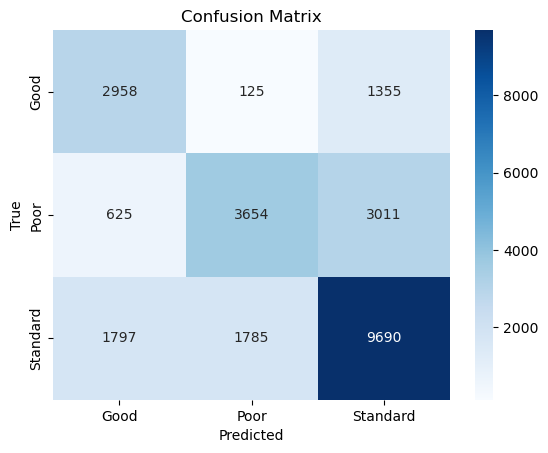

In [53]:
cm = confusion_matrix(y_test, y_pred_dt)
labels = ['Good', 'Poor','Standard'] # set the labes, otherwise it will show [0,1,2]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [151]:
# default iter = 100
print("Accuracy is:", grid_search.score(X_test, y_test))
print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Accuracy is: 0.65224
Best params: {'C': 100}
Best score: 0.6512800000000001


In [129]:
# data version 2, increase max_iter
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]}  # 正則化強度

logclf = LogisticRegression(max_iter = 500)
grid_search = GridSearchCV(logclf, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='accuracy',
             verbose=1)

In [130]:
# default iter = 500
print("Accuracy is:", grid_search.score(X_test, y_test))
print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Accuracy is: 0.65252
Best params: {'C': 100}
Best score: 0.6512800000000001


In [131]:
# data version 2, change C
param_grid = {
    'C': [100, 300, 600]}  # 正則化強度

logclf = LogisticRegression(max_iter = 500)
grid_search = GridSearchCV(logclf, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [100, 300, 600]}, scoring='accuracy', verbose=1)

In [132]:
# default iter = 500, bigger C
print("Accuracy is:", grid_search.score(X_test, y_test))
print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Accuracy is: 0.65256
Best params: {'C': 300}
Best score: 0.6512933333333333


## Date version 1, dataset drop annual income
The performance is worse than data version 2

Apologies for the Chinese text in the output. I did not rerun these versions of the models because they do not provide meaningful results, and the high iteration setting incurs high computational cost. The codes include a Chinese translation of the output into English. I kept this part only to demonstrate the trial-and-error process.

In [74]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]}  

logclf = LogisticRegression(max_iter = 500)
grid_search = GridSearchCV(logclf, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='accuracy',
             verbose=1)

In [73]:
# default iter = 100
print("Accuracy is:", grid_search.score(X_test, y_test))
print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Accuracy is: 0.53536
最佳參數: {'C': 10}
最佳分數: 0.5352533333333334


In [75]:
# max iter = 500
print("Accuracy is:", grid_search.score(X_test, y_test))
print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Accuracy is: 0.60052
最佳參數: {'C': 0.01}
最佳分數: 0.60156


In [108]:
log_1000 = LogisticRegression(max_iter = 1000)
grid_1000 = GridSearchCV(log_1000, param_grid, cv = 5, scoring='accuracy', verbose=1)
grid_1000.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='accuracy', verbose=1)

In [77]:
# max iter = 1000
print("Accuracy is:", grid_search.score(X_test, y_test))
print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Accuracy is: 0.61556
最佳參數: {'C': 1}
最佳分數: 0.6112666666666666


In [102]:
# Hyperparameter Tuning
param_grid = {
    #'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs'], # saga can use l1
    'penalty': ['l2']  # Use 'elasticnet' for combining L1 and L2
}  

In [86]:
logclf = LogisticRegression(max_iter = 2000)
grid_2000 = GridSearchCV(logclf, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_2000.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: C

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=2000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'saga']},
             scoring='accuracy', verbose=1)

In [88]:
# max iter = 2000
print("Accuracy is:", grid_2000.score(X_test, y_test))

print("Best params:", grid_2000.best_params_)
print("Best score:", grid_2000.best_score_)

Accuracy is: 0.62356
Best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best score: 0.6190266666666666


In [89]:
y_pred = grid_2000.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Good       0.53      0.37      0.44      4438
        Poor       0.66      0.49      0.56      7290
    Standard       0.63      0.78      0.70     13272

    accuracy                           0.62     25000
   macro avg       0.61      0.55      0.57     25000
weighted avg       0.62      0.62      0.61     25000



### Change solver
- This part use data version 1
- Default solver is lbfgs

In [78]:
# Use another solver
log_saga = LogisticRegression(solver='saga', max_iter=1000)
grid_search = GridSearchCV(log_saga, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/sit

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, solver='saga'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='accuracy',
             verbose=1)

In [87]:
# log_saga, max iter = 1000
print("Accuracy is:", grid_search.score(X_test, y_test))

print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Accuracy is: 0.56792
Best params: {'C': 0.01}
Best score: 0.55976


In [81]:
from sklearn.metrics import classification_report

In [83]:
y_pred = grid_search.predict(X_test)

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Good       0.52      0.03      0.06      4438
        Poor       0.59      0.37      0.46      7290
    Standard       0.56      0.85      0.68     13272

    accuracy                           0.57     25000
   macro avg       0.56      0.42      0.40     25000
weighted avg       0.56      0.57      0.50     25000



In [91]:
from sklearn.ensemble import VotingClassifier

In [100]:
# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('grid_1000', grid_1000),
    ('log_saga', grid_search)
], voting='soft')

# Stratified K-Fold Cross Validation
#skf = StratifiedKFold(n_splits=8)

In [105]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [104]:
# Train the model
voting_clf.fit(X_train, y_train)

# Predictions
y_pred = voting_clf.predict(X_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: C

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anniechen/anaconda3/lib/python3.11/sit

NameError: name 'confusion_matrix' is not defined

In [113]:
# log_saga, max iter = 1000
print("Accuracy is:", voting_clf.score(X_test, y_test))

#print("Best params:", voting_clf.best_params_)
print("Best score:", voting_clf.best_score_)

Accuracy is: 0.6006


AttributeError: 'VotingClassifier' object has no attribute 'best_score_'

In [106]:
confusion_matrix(y_test, y_pred)

array([[  768,    54,  3616],
       [  125,  3247,  3918],
       [  556,  1716, 11000]])

In [107]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        Good       0.53      0.17      0.26      4438
        Poor       0.65      0.45      0.53      7290
    Standard       0.59      0.83      0.69     13272

    accuracy                           0.60     25000
   macro avg       0.59      0.48      0.49     25000
weighted avg       0.60      0.60      0.57     25000



In [109]:
# Check the category distribution of the Y
print(df['Credit_Score'].value_counts())

# in %
print(df['Credit_Score'].value_counts(normalize=True) * 100)


Standard    53174
Poor        28998
Good        17828
Name: Credit_Score, dtype: int64
Standard    53.174
Poor        28.998
Good        17.828
Name: Credit_Score, dtype: float64
